In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow import keras
import os
import sys
import scipy as sp
from scipy.special import rel_entr
from textwrap import wrap
from matplotlib import animation
from IPython.display import HTML

In [2]:
def load_jet_data_log_scaling_new(data_path):
    """Load and normalize the jet data

    Scale Pt and E by taking the log
    Args:
        data_path (path-like): path to txt file with jet 4-momenta

    Returns:
        tuple: tuple of ndarrays (parton_data, reco_data)
    """
    data = np.loadtxt(data_path, skiprows=2, dtype=np.float32)
    np.log10(data[:, 3], out=data[:, 3])
    np.log10(data[:, 7], out=data[:, 7])
    
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    
    data = (data - mean) / std

    np.random.shuffle(data)
    parton_data = data[:, :4]
    reco_data = data[:, 4:]
    return (parton_data, reco_data)

In [3]:
class SingleDistribution:
    def __init__(self, true_distribution, predicted_distributions, axis_limits, iteration_interval):
        self.fig = plt.figure(figsize=(10, 5), dpi=200)
        self.iteration_interval = iteration_interval
        self.axis_limits = axis_limits
        self.true_distribution = true_distribution
        self.predicted_distributions = predicted_distributions


        self.ax = self.fig.add_subplot(111)
        self.ax.set_title("True and Predicted Pt Distributions")
        self.ax.set_xlabel("Pt")
        self.ax.set_ylabel("Count")
        self.bins = np.linspace(axis_limits[0], axis_limits[1], 100)
        self.ax.hist(true_distribution, label="True Reco Jet Pt", bins=self.bins, alpha=0.5, ec="k", histtype='stepfilled')
        self.ax.hist([], label="Predicted Jet Pt", bins=self.bins, alpha=0.5, ec="k", histtype='stepfilled')
        self.ax.legend()
        self.num_frames = len(predicted_distributions)
        
        
    def init(self):
        pass
        
    def update(self, frame):
        self.ax.cla()
        self.ax.hist(self.true_distribution, label="True Reco Jet Pt", bins=self.bins, alpha=0.5, ec="k", histtype='stepfilled')
        self.ax.hist(self.predicted_distributions[frame], label="Predicted Jet Pt", bins=self.bins, alpha=0.5, ec="k", histtype='stepfilled')
        self.ax.set_title("True and Predicted Pt Distributions Iteration: {}".format(frame*self.iteration_interval))
        self.ax.legend()
        self.ax.set_xlim(self.axis_limits[0], self.axis_limits[1])
        self.ax.set_ylim(self.axis_limits[2], self.axis_limits[3])
            
    def make_animation(self):
        anim = animation.FuncAnimation(
            self.fig,
            self.update,
            init_func=self.init,
            frames=np.arange(self.num_frames),
            interval=500,
        )
        return anim

In [4]:
def pt(a, b):
    return np.sqrt(a**2 + b**2)

In [5]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [40]:
sys.path.append('../models/cWGAN/Run_2021-03-31_0/')
import cWGAN
save_dir = '../models/cWGAN/Run_2021-03-31_0/'
assert(os.path.isdir(save_dir))

In [41]:
data = np.loadtxt("../data/processed/newPartonMatchedJetsNoRecoPtCutCartesian.txt", skiprows=2)

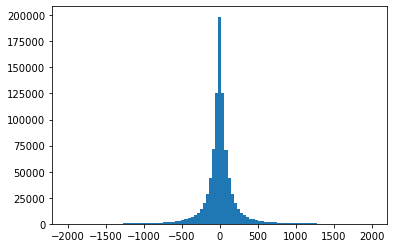

In [42]:
bins = np.linspace(-2000, 2000, 100)
plt.hist(data[:, 6], bins=bins)
plt.show()

In [43]:
normalized_data = np.zeros((len(data), 4))
reco_data = np.zeros((len(data), 4))

np.log10(data[:, 3], out=normalized_data[:, 3])
np.log10(data[:, 7], out=reco_data[:, 3])

normalized_data[:, :3] = data[:, :3]
reco_data[:, :3] = data[:, 4:7]

normalized_mean = np.mean(normalized_data, axis=0)
normalized_std = np.std(normalized_data, axis=0)
print(normalized_std)
reco_mean = np.mean(reco_data, axis=0)
reco_std = np.std(reco_data, axis=0)
print(reco_std)

normalized_data = (normalized_data - normalized_mean) / normalized_std

[ 58.81692871  58.62906645 311.782445     0.40070437]
[ 53.79047245  53.55804169 256.80206613   0.40304906]


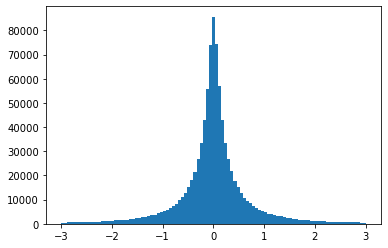

In [44]:
bins = np.linspace(-3, 3, 100)
plt.hist(normalized_data[:, 2], bins=bins)
plt.show()

In [45]:
cwgan = cWGAN.cWGAN(10, "RMSprop", 0.000002, 0.00001, 10, False, "", 0)

In [66]:
cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_190000')

In [67]:
%%time
predict = np.array(cwgan.make_generator_predictions(normalized_data))

CPU times: user 1min 9s, sys: 8.34 s, total: 1min 18s
Wall time: 2.92 s


In [68]:
predict = predict * reco_std + reco_mean
predict[:, 3] = 10**predict[:, 3]

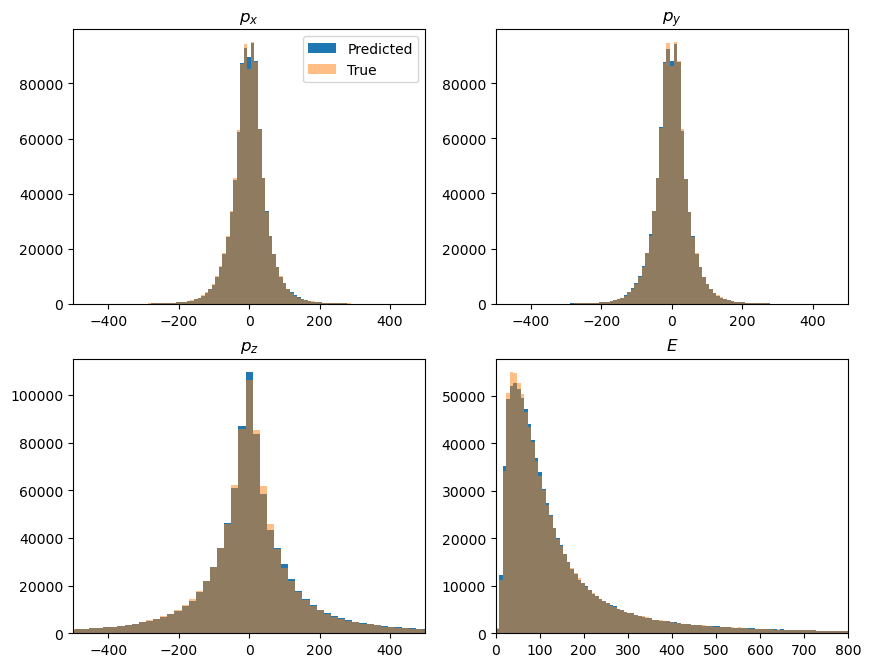

In [69]:
bins = np.linspace(-500, 500, 100)
fig = plt.figure(figsize=(10,8), dpi=100)

ax1 = fig.add_subplot(221)
ax1.hist(predict[:, 0], bins=bins, label='Predicted')
ax1.hist(data[:, 4], bins=bins, label='True', alpha=0.5)
ax1.set_xlim(-500, 500)
ax1.set_title(r'$p_x$')
ax1.legend()

ax2 = fig.add_subplot(222)
ax2.hist(predict[:, 1], bins=bins)
ax2.hist(data[:, 5], bins=bins, alpha=0.5)
ax2.set_xlim(-500, 500)
ax2.set_title(r'$p_y$')

bins = np.linspace(-1000, 1000, 100)
ax3 = fig.add_subplot(223)
ax3.hist(predict[:, 2], bins=bins)
ax3.hist(data[:, 6], bins=bins, alpha=0.5)
ax3.set_xlim(-500, 500)
ax3.set_title(r'$p_z$')

bins = np.linspace(0, 800, 100)
ax4 = fig.add_subplot(224)
ax4.hist(predict[:, 3], bins=bins)
ax4.hist(data[:, 7], bins=bins, alpha=0.5)
ax4.set_xlim(0, 800)
ax4.set_title(r'$E$')

plt.show()

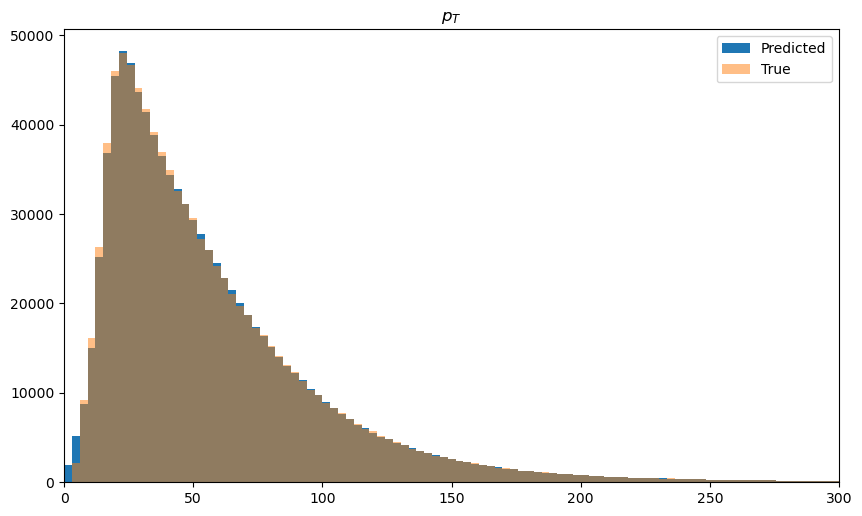

In [70]:
bins = np.linspace(0, 300, 100)
fig = plt.figure(figsize=(10,6), dpi=100)
ax = fig.add_subplot(111)
ax.hist(np.sqrt(predict[:, 0]**2 + predict[:, 1]**2), bins=bins, label="Predicted")
ax.hist(np.sqrt(data[:, 4]**2 + data[:, 5]**2), bins=bins, alpha=0.5, label="True")
ax.set_xlim(0, 300)
ax.set_title(r'$p_T$')
ax.legend()
plt.show()

In [61]:
single_distributions = []
for i in range(145):
    iteration = str(i*10000)
    if i % 10 == 0:    
        print(iteration)
    cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_' + iteration)
    predict = np.array(cwgan.make_generator_predictions(normalized_data))
    predict = predict * reco_std + reco_mean   
    single_distributions.append(np.sqrt(predict[:, 0]**2 + predict[:, 1]**2))

0


KeyboardInterrupt: 

In [ ]:
sd = SingleDistribution(np.sqrt(data[:, 4]**2 + data[:, 5]**2), single_distributions, (0, 300, 0, 50000), 10000)
anim = sd.make_animation()
HTML(anim.to_jshtml())

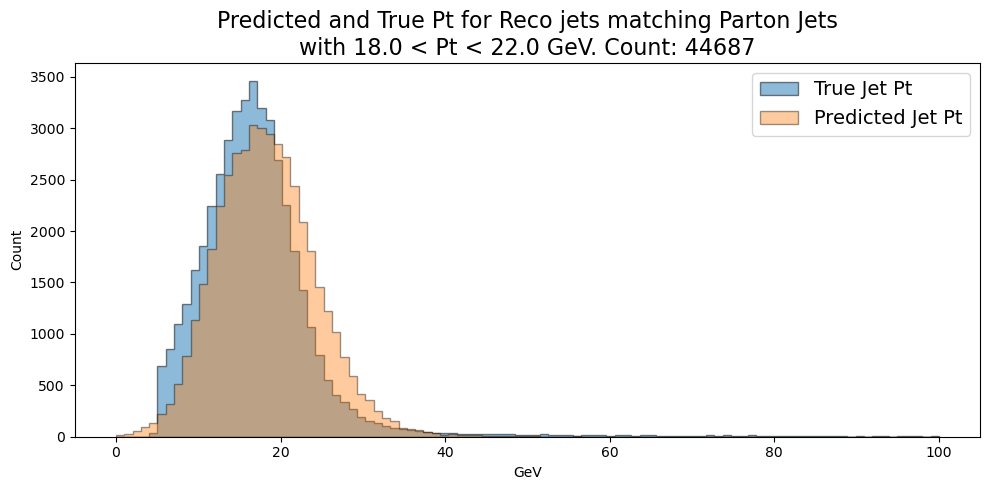

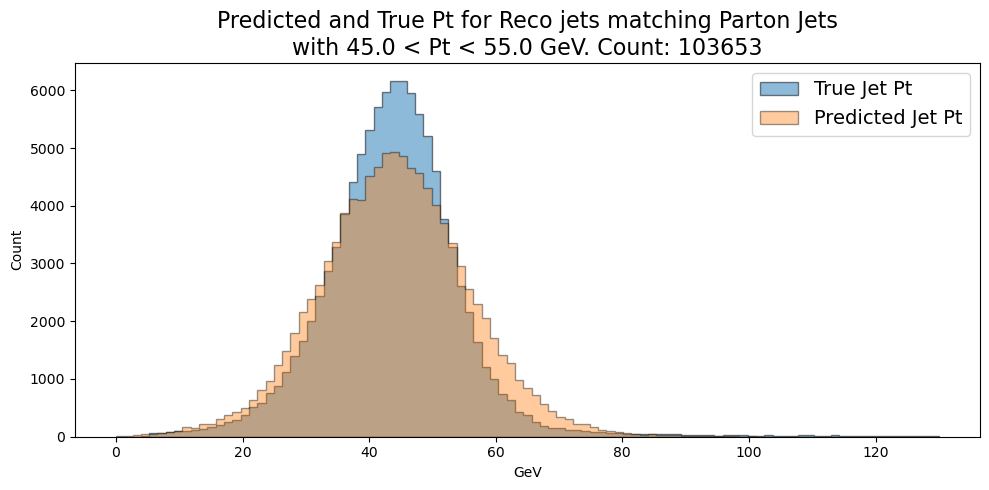

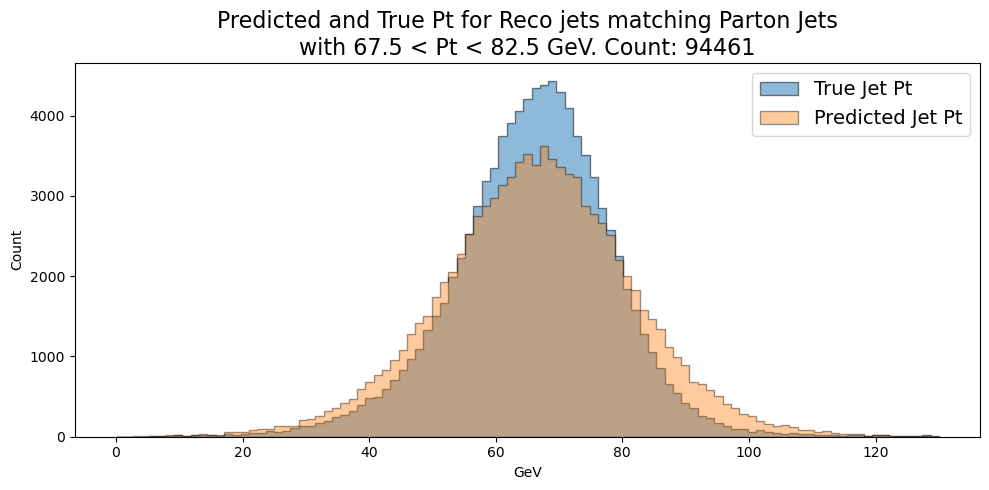

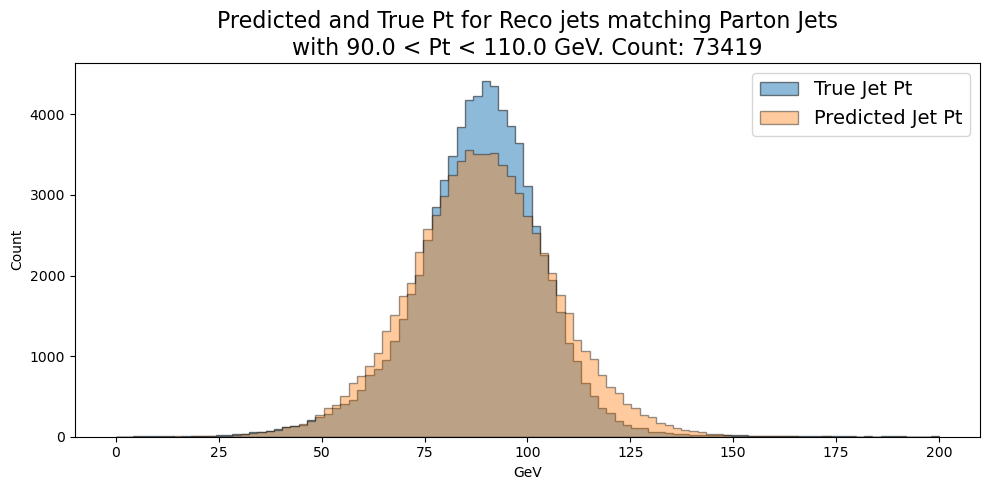

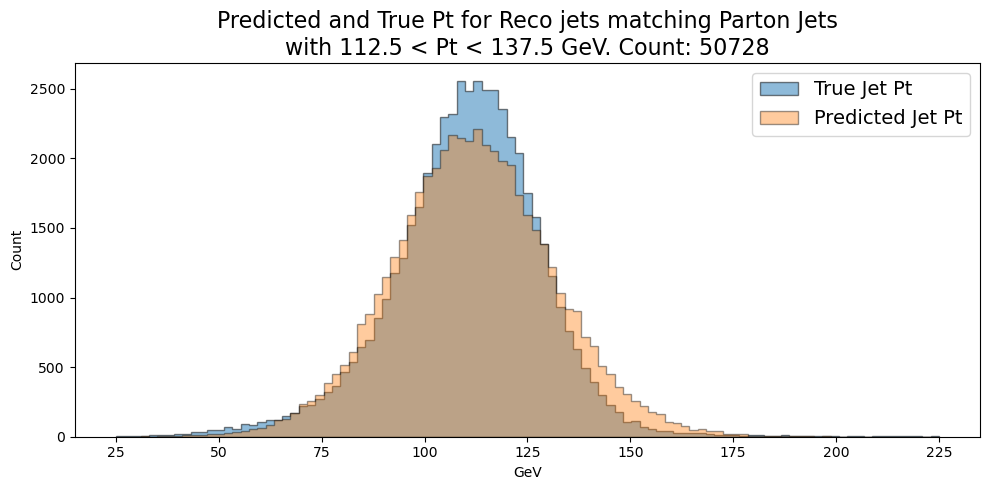

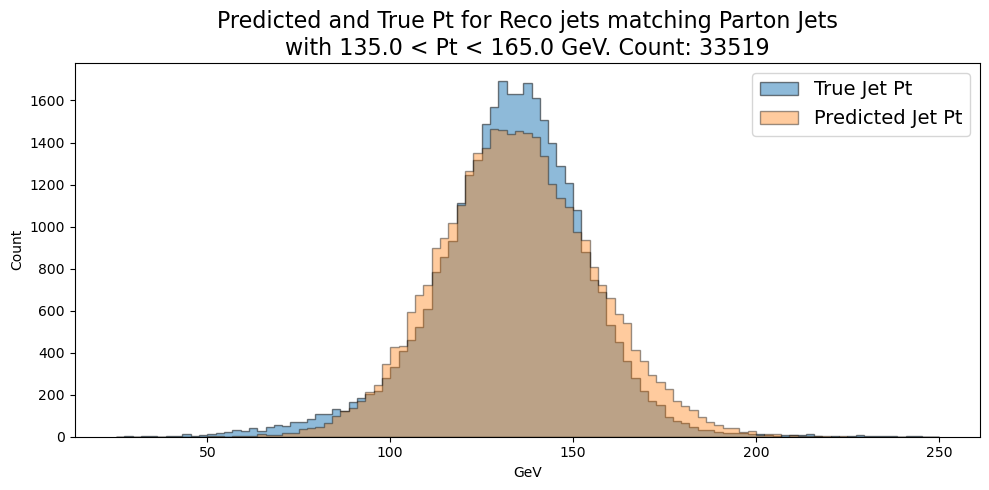

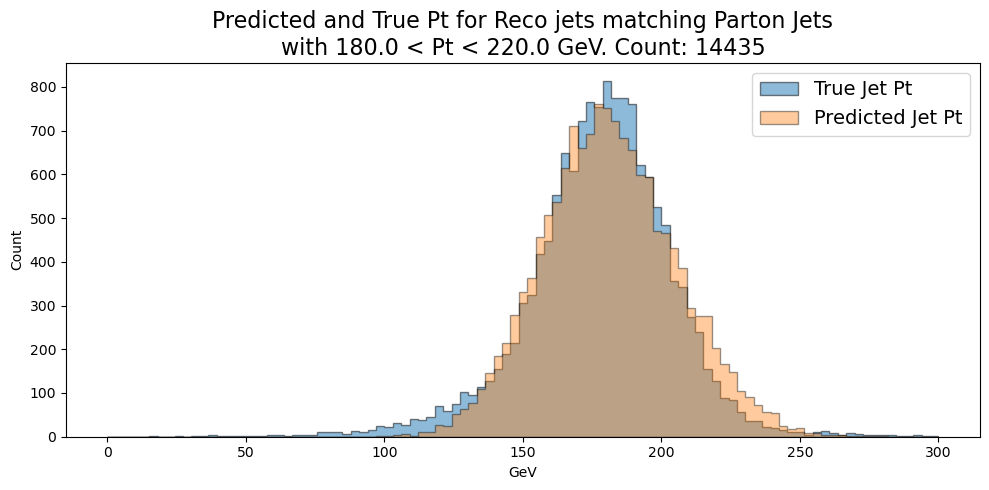

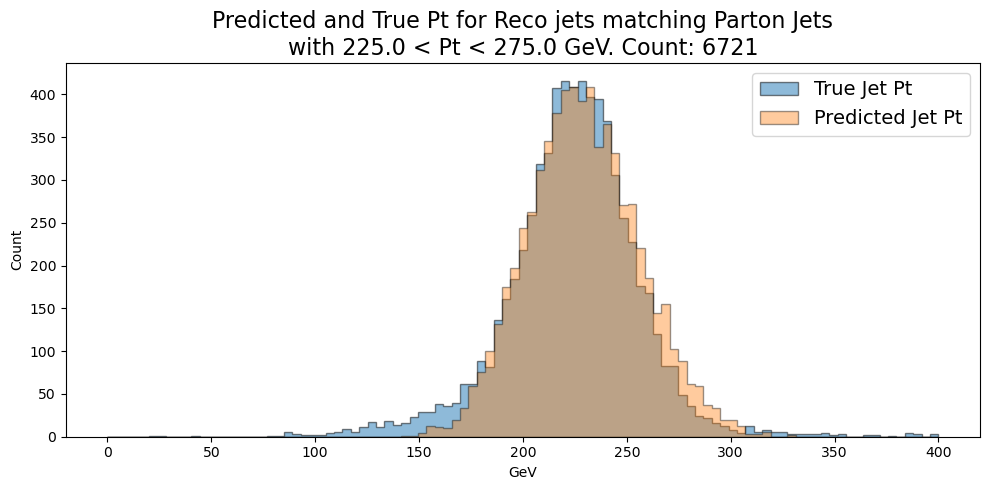

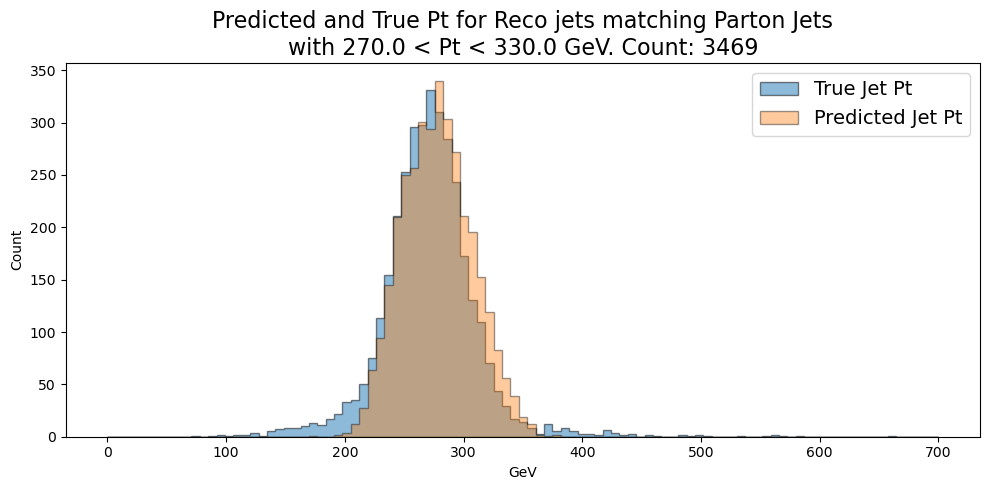

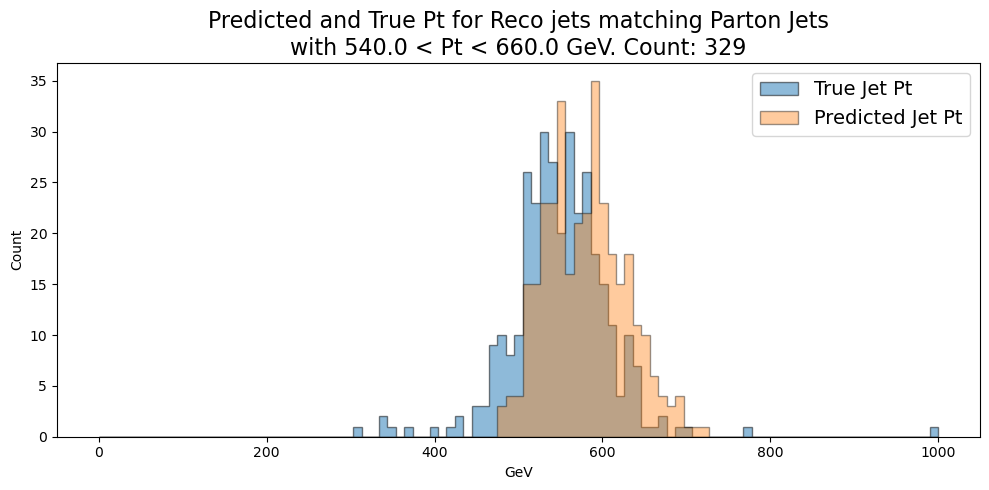

In [62]:
range_highs = [100, 130, 130, 200, 225, 250, 300, 400, 700, 1000]
range_lows = [0, 0, 0, 0, 25, 25, 0, 0, 0, 0]
j = 0
for center in [20, 50, 75, 100, 125, 150, 200, 250, 300, 600]:        
    recoPt = []
    predPt = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (pt(data[i, 0], data[i, 1]) > low and pt(data[i, 0], data[i, 1]) < high):
            recoPt.append(pt(data[i, 4], data[i, 5]))
            predPt.append(pt(predict[i, 0], predict[i, 1]))
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoPt, bins=bins, label='True Jet Pt', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predPt, bins=bins, label='Predicted Jet Pt', alpha=0.4, ec="k", histtype='stepfilled')
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap("Predicted and True Pt for Reco jets matching Parton Jets with {} < Pt < {} GeV. Count: {}".format(low, high, len(recoPt)), width=60)), fontsize=16)
    #ax.axvline(x=center/2)

    ax.legend(fontsize=14)
    plt.tight_layout()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig(save_dir+"/PtDistLog{}.png".format(j), facecolor="white", transparent="True")
    j+=1

In [80]:
def momentum(vec):
    return np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)

def invarientMass(vec):
    psquared = vec[0]**2 + vec[1]**2 + vec[2]**2
    return vec[3]**2 - psquared

def theta(vec):
    psquared = vec[0]**2 + vec[1]**2 + vec[2]**2
    return np.arccos(vec[3]/np.sqrt(psquared))

def eta(vec):
    angle = theta(vec)
    return -np.log(np.tan(angle/2))

def eta2(vec):
    p = np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)
    return np.arctanh(vec[2]/p)



In [79]:
for i in range(5):
    print(data[i, 4:])
    print(predict[i])
    print(psquared(data[i, 4:]))
    print(psquared(predict[i]))
    print("")

[ 23.2545 -27.9664 -58.2017  69.0265]
[ 27.16251306 -35.11724916 -70.54734906  87.73065678]
68.63183796242092
83.35437459443311

[  26.1593  -35.318  -157.314   163.656 ]
[  29.90312751  -35.91465579 -182.71394627  189.77727735]
163.33819117551778
188.59598537184434

[ -48.6765     6.86655 -144.961    153.321  ]
[ -59.98941841   10.9050916  -180.35868975  194.0769079 ]
153.0694047879997
190.386208300593

[  35.5614   49.4614 -244.598   252.254 ]
[  35.10393908   47.89719576 -250.89786664  255.73064948]
252.069880913845
257.8297255630628

[-45.0231 -11.9126 -60.666   77.0096]
[-67.91311436 -20.72245858 -86.21722409 118.30306736]
76.48106385485232
111.69163407108799



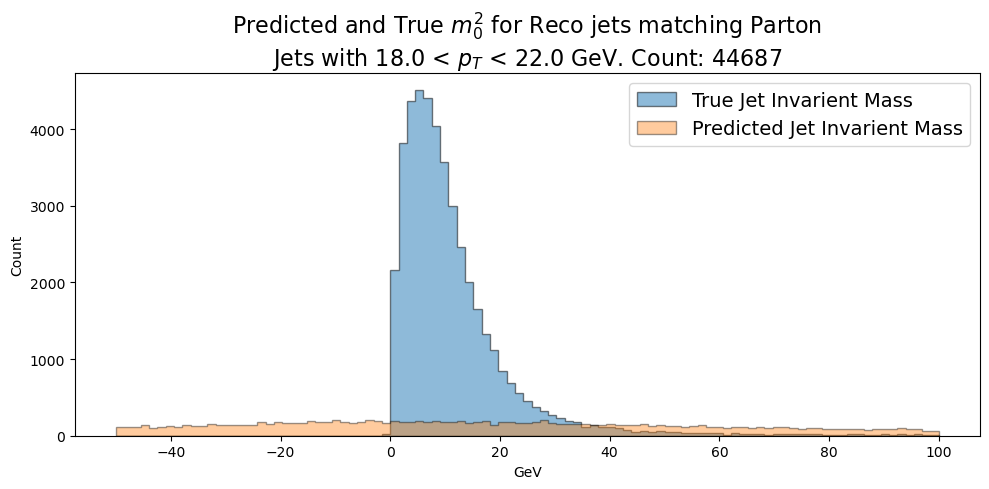

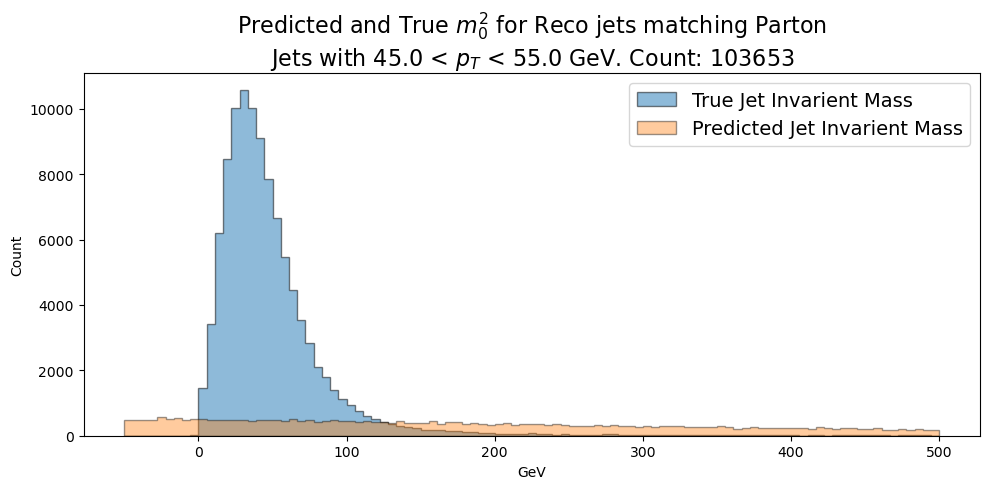

In [90]:
range_highs = [100, 500, 500, 500, 500, 1000, 1000, 1000, 2000, 2000]
range_lows = [-50, -50, -50, -50, -50, -50, -50, -50, -50, -50]
j = 0
for center in [20, 50]:#, 75, 100, 125, 150, 200, 250, 300, 600]:        
    recoM = []
    predM = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (pt(data[i, 0], data[i, 1]) > low and pt(data[i, 0], data[i, 1]) < high):
            recoM.append(invarientMass(data[i, 4:]))
            predM.append(invarientMass(predict[i]))
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoM, bins=bins, label='True Jet Invarient Mass', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predM, bins=bins, label='Predicted Jet Invarient Mass', alpha=0.4, ec="k", histtype='stepfilled')
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap(r"Predicted and True $m_0^2$ for Reco jets matching Parton Jets with {} < $p_T$ < {} GeV. Count: {}".format(low, high, len(recoM)), width=60)), fontsize=16)

    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    j+=1

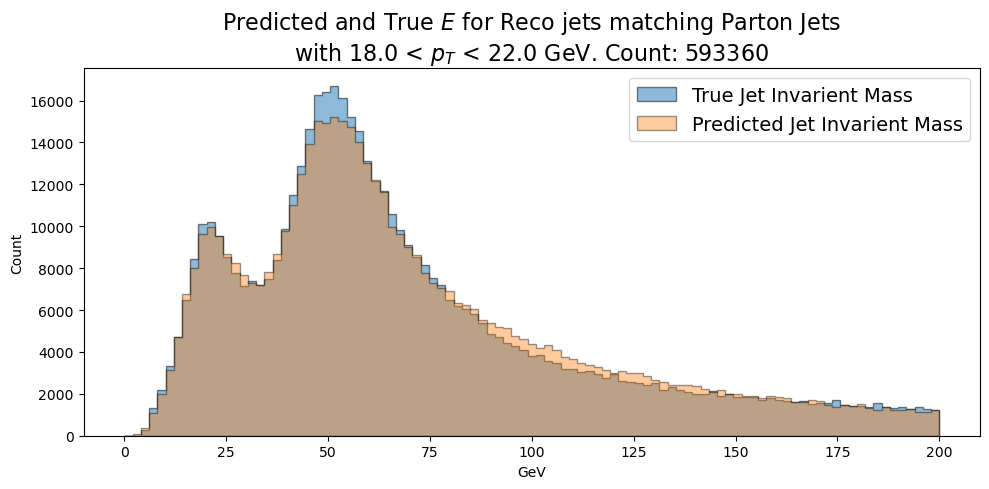

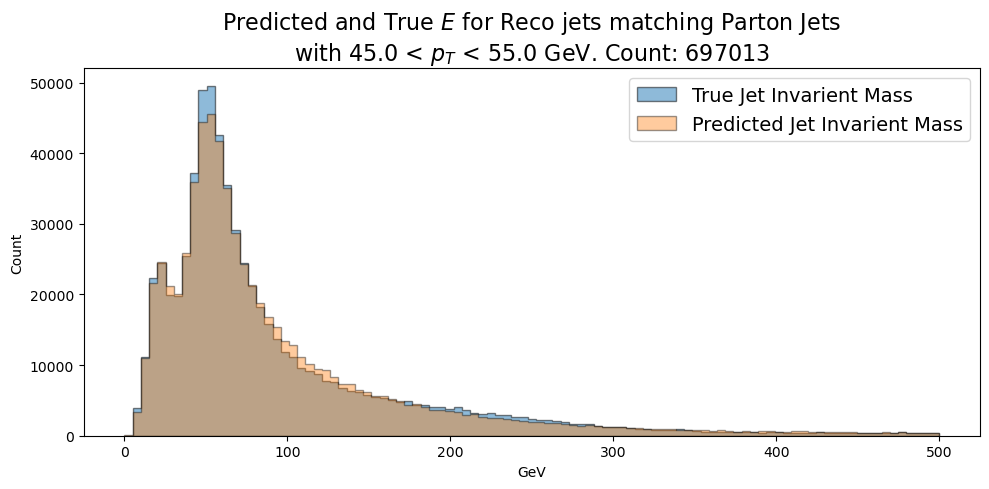

In [86]:
range_highs = [200, 500, 500, 500, 500, 1000, 1000, 1000, 2000, 2000]
range_lows = [0, 0, -50, -50, -50, -50, -50, -50, -50, -50]
j = 0
for center in [20, 50]:#, 75, 100, 125, 150, 200, 250, 300, 600]:        
    recoE = []
    predE = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (pt(data[i, 0], data[i, 1]) > low and pt(data[i, 0], data[i, 1]) < high):
            recoM.append(data[i, 7])
            predM.append(predict[i, 3])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoM, bins=bins, label='True Jet Invarient Mass', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predM, bins=bins, label='Predicted Jet Invarient Mass', alpha=0.4, ec="k", histtype='stepfilled')
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap(r"Predicted and True $E$ for Reco jets matching Parton Jets with {} < $p_T$ < {} GeV. Count: {}".format(low, high, len(recoM)), width=60)), fontsize=16)

    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    j+=1

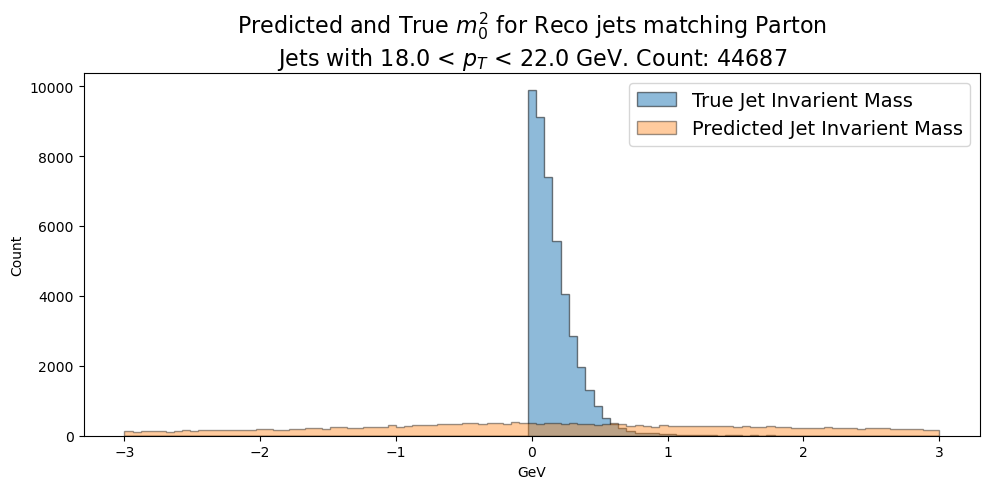

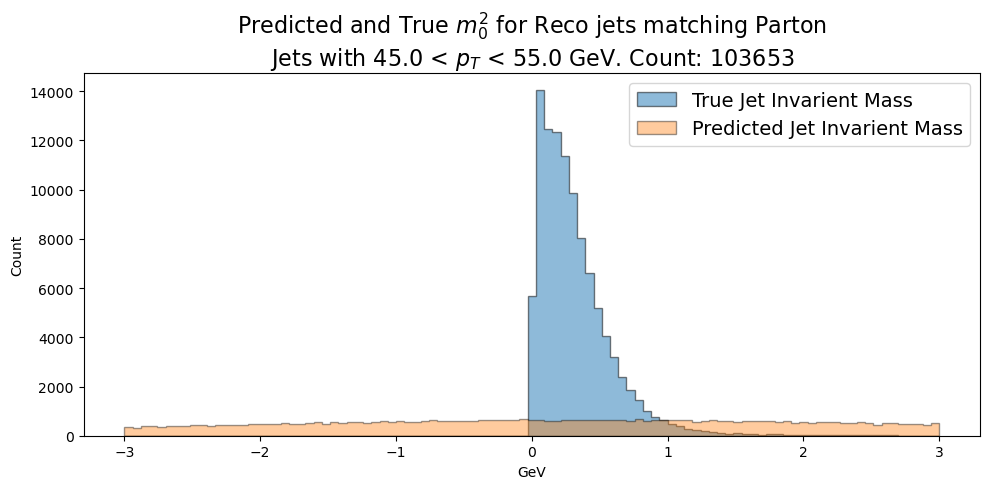

In [88]:
range_highs = [3, 3, 500, 500, 500, 1000, 1000, 1000, 2000, 2000]
range_lows = [-3, -3, -50, -50, -50, -50, -50, -50, -50, -50]
j = 0
for center in [20, 50]:#, 75, 100, 125, 150, 200, 250, 300, 600]:        
    recoM = []
    predM = []
    low = center - center/10
    high = center + center/10
    for i in range(len(data)):
        if (pt(data[i, 0], data[i, 1]) > low and pt(data[i, 0], data[i, 1]) < high):
            recoM.append(data[i, 7] - momentum(data[i, 4:]))
            predM.append(predict[i, 3] - momentum(predict[i]))
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(10,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoM, bins=bins, label='True Jet Invarient Mass', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predM, bins=bins, label='Predicted Jet Invarient Mass', alpha=0.4, ec="k", histtype='stepfilled')
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap(r"Predicted and True $m_0^2$ for Reco jets matching Parton Jets with {} < $p_T$ < {} GeV. Count: {}".format(low, high, len(recoM)), width=60)), fontsize=16)

    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    j+=1